# CE-40717: Machine Learning

## HW8-Clustering & Reinforcement Learning

Amir Pourmand - 99210259

### Kmeans & GMM:

At this question, we tend to implement Kmeans & GMM algorithms. For this purpose, `DO NOT EMPLOY` ready-for-use python libraries. Use this implementation for solving the following questions. Kmeans should continue till centeroids won't change. Furthermore, GMM also should continue till the difference of two consecutive likelihood logarithm would be less than 0.1. Notice that after executing the Kmeans part, the primitive centroids of GMM should be identical with ultimate Kmeans centroids.

In [8]:
from sklearn.datasets.samples_generator import make_classification, make_moons, make_circles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/amir/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Part 1:

Utilize the subsequent cell in order to create the Dataset. Afterwards, try to execute the algorithm with k=2 centroids. At Kmeans, it is recommended to execute the algorithm with several various starting states in order to eventually choose the best respective result.

In [9]:
X,Y = make_classification(n_samples=700, n_features=10, n_informative=5,
                          n_redundant=0, n_clusters_per_class=2, n_classes=3)

## KMeans Implementation

In [10]:
class KMeans:

    def __init__(self, n_clusters = 3, tolerance = 0.01, max_iter = 100, runs = 1):
        self.n_clusters = n_clusters
        self.tolerance = tolerance
        self.cluster_means = np.zeros(n_clusters)
        self.max_iter = max_iter
        self.runs = runs
        
    def fit(self, X,Y):
        row_count, col_count = X.shape
        
        X_values = self.__get_values(X)
        
        X_labels = np.zeros(row_count)
        
        costs = np.zeros(self.runs)
        all_clusterings = []

        for i in range(self.runs):
            cluster_means =  self.__initialize_means(X_values, row_count)

            for _ in range(self.max_iter):            
                previous_means = np.copy(cluster_means)
                
                distances = self.__compute_distances(X_values, cluster_means, row_count)
            
                X_labels = self.__label_examples(distances)
            
                cluster_means = self.__compute_means(X_values, X_labels, col_count)

                clusters_not_changed = np.abs(cluster_means - previous_means) < self.tolerance
                if np.all(clusters_not_changed) != False:
                    break
            
            X_values_with_labels = np.append(X_values, X_labels[:, np.newaxis], axis = 1)
            
            all_clusterings.append( (cluster_means, X_values_with_labels) )
            costs[i] = self.__compute_cost(X_values, X_labels, cluster_means)
        
        best_clustering_index = costs.argmin()
        
        self.costs = costs
        self.cost_ = costs[best_clustering_index]
        
        self.centroid,self.items = all_clusterings[best_clustering_index]
        self.y = Y
        return all_clusterings[best_clustering_index]
        
    def __initialize_means(self, X, row_count):
        return X [ np.random.choice(row_count, size=self.n_clusters, replace=False) ]
        
        
    def __compute_distances(self, X, cluster_means, row_count):
        distances = np.zeros((row_count, self.n_clusters))
        for cluster_mean_index, cluster_mean in enumerate(cluster_means):
            distances[:, cluster_mean_index] = np.linalg.norm(X - cluster_mean, axis = 1)
            
        return distances
    
    def __label_examples(self, distances):
        return distances.argmin(axis = 1)
    
    def __compute_means(self, X, labels, col_count):
        cluster_means = np.zeros((self.n_clusters, col_count))
        for cluster_mean_index, _ in enumerate(cluster_means):
            cluster_elements = X [ labels == cluster_mean_index ]
            if len(cluster_elements):
                cluster_means[cluster_mean_index, :] = cluster_elements.mean(axis = 0)
                
        return cluster_means
    
    def __compute_cost(self, X, labels, cluster_means):
        cost = 0
        for cluster_mean_index, cluster_mean in enumerate(cluster_means):
            cluster_elements = X [ labels == cluster_mean_index ]
            cost += np.linalg.norm(cluster_elements - cluster_mean, axis = 1).sum()
        
        return cost
            
    def __get_values(self, X):
        if isinstance(X, np.ndarray):
            return X
        return np.array(X)
    
    def predict(self):
        data=pd.DataFrame(self.items)
        added_column=list(data.columns)[-1]
        data['Label'] = self.y
        resultOfClustering=data.groupby([added_column])['Label'].agg(lambda x: x.value_counts().index[0])
        mapping = dict()
        for label in range(self.n_clusters):
            label_predicted = resultOfClustering[label]
            mapping[label] = label_predicted
        data['PredictedLabels']=data[added_column].map(mapping)
        return np.array(data['PredictedLabels'])

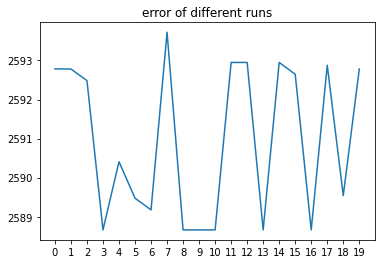

In [11]:
kmeans=KMeans(2,max_iter=10000,runs=20)
centroids,kmeans_items=kmeans.fit(X,Y)
plt.plot(np.arange(len(kmeans.costs)),kmeans.costs)
plt.title('error of different runs')
plt.xticks(np.arange(len(kmeans.costs)))
plt.show();

## Gaussian Mixture Model Implementation

In [12]:
import numpy as np

import scipy.stats as sp
class GaussianMixModel():
    def __init__(self, X, k=2):
        X = np.asarray(X)
        self.m, self.n = X.shape
        self.data = X.copy()
        self.k = k
        
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.Z = np.asmatrix(np.empty((self.m, self.k), dtype=float))

     
    def initialize_means(self,means):
        self.mean_arr = means
    
    def fit(self, tol=0.1):

        num_iters = 0
        logl = 1
        previous_logl = 0
        while(logl-previous_logl > tol):
            previous_logl = self.loglikelihood()
            self.e_step()
            self.m_step()
            num_iters += 1
            logl = self.loglikelihood()
            print('Iteration %d: log-likelihood is %.6f'%(num_iters, logl))
        print('Terminate at %d-th iteration:log-likelihood is %.6f'%(num_iters, logl))

    def loglikelihood(self):
        logl = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                tmp += sp.multivariate_normal.pdf(self.data[i, :],self.mean_arr[j, :].A1,self.sigma_arr[j, :]) * self.phi[j]
            logl += np.log(tmp)
        return logl


    def e_step(self):
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                num = sp.multivariate_normal.pdf(self.data[i, :],
                                                       self.mean_arr[j].A1,
                                                       self.sigma_arr[j]) *\
                      self.phi[j]
                den += num

                self.Z[i, j] = num
            self.Z[i, :] /= den
            assert self.Z[i, :].sum() - 1 < 1e-4  # Program stop if this condition is false

    def m_step(self):
         for j in range(self.k):
            const = self.Z[:, j].sum()
            self.phi[j] = 1/self.m * const
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.Z[i, j])
                _sigma_j += self.Z[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))

            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = _sigma_j / const
    
    def predict(self):
        return np.array(np.argmax(gmm.Z,axis=1)).flatten()

In [13]:
gmm=GaussianMixModel(X,k=2)
gmm.initialize_means(np.asmatrix(centroids))
gmm.fit()

Iteration 1: log-likelihood is -11240.664685
Iteration 2: log-likelihood is -11217.578370
Iteration 3: log-likelihood is -11207.984489
Iteration 4: log-likelihood is -11203.316664
Iteration 5: log-likelihood is -11200.584656
Iteration 6: log-likelihood is -11198.589541
Iteration 7: log-likelihood is -11196.950208
Iteration 8: log-likelihood is -11195.598834
Iteration 9: log-likelihood is -11194.560923
Iteration 10: log-likelihood is -11193.809382
Iteration 11: log-likelihood is -11193.259931
Iteration 12: log-likelihood is -11192.838590
Iteration 13: log-likelihood is -11192.504004
Iteration 14: log-likelihood is -11192.235454
Iteration 15: log-likelihood is -11192.019740
Iteration 16: log-likelihood is -11191.845614
Iteration 17: log-likelihood is -11191.703256
Iteration 18: log-likelihood is -11191.584824
Iteration 19: log-likelihood is -11191.484495
Iteration 20: log-likelihood is -11191.398087
Terminate at 20-th iteration:log-likelihood is -11191.398087


#### Part 2:

In a separated cell, implement `Purity` and `Rand-Index` criteria in order to compare the performance of mentioned algorithms.

## KMeans 

In [ ]:
print('Purity Of kmeans: ',np.sum(kmeans.predict()==Y)/len(Y))

In [447]:
from scipy.special import comb
def rand_index_score(clusters, classes):
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = comb(np.bincount(clusters), 2).sum() - tp
    fn = comb(np.bincount(classes), 2).sum() - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [448]:
print('rand index of kmeans', rand_index_score(kmeans.predict(),Y))

rand index of kmeans 0.626176170038831


## Gaussian Mixture Model

In [449]:
print('purity index: ', np.sum(gmm.predict() == Y)/len(Y))

purity index:  0.3442857142857143


In [450]:
print('rand index', rand_index_score(gmm.predict(),Y))

rand index 0.6612957285918659


#### Part 3:

Use the following cell in order to create new Datasets. Afterwards, try to execute mentioned algorithms on new Dataset and eventually compare the recent results with the help of visualization(there is no problem for using relevant python libraries like `matplotlib`). Consider two clusters for this part.

In [496]:
X, Y = make_classification(n_samples=700, n_features=2, n_informative=2, n_redundant=0, n_classes=2)

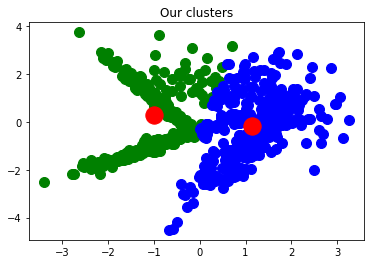

In [497]:
k=2
kmeans=KMeans(k,max_iter=10000,runs=20)
centroids,kmeans_items=kmeans.fit(X,Y)

color_s =["green","blue","navy","maroon",'orange'] 
for i in range(k):
    plt.scatter(kmeans_items[kmeans_items[:,2]==i,0] , kmeans_items[kmeans_items[:,2]==i,1] 
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(centroids[:,0] , centroids[:,1] , s = 300, color = 'red')
plt.title('Our clusters')
plt.show();

Iteration 1: log-likelihood is -2315.565750
Iteration 2: log-likelihood is -2306.061991
Iteration 3: log-likelihood is -2300.517351
Iteration 4: log-likelihood is -2297.679316
Iteration 5: log-likelihood is -2296.523375
Iteration 6: log-likelihood is -2296.079572
Iteration 7: log-likelihood is -2295.873169
Iteration 8: log-likelihood is -2295.745392
Iteration 9: log-likelihood is -2295.650630
Terminate at 9-th iteration:log-likelihood is -2295.650630


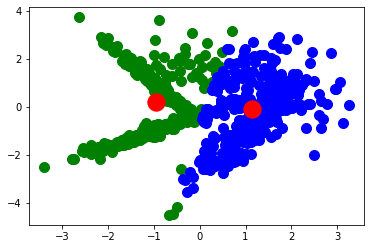

In [498]:
gmm=GaussianMixModel(X,k)
gmm.initialize_means(np.asmatrix(centroids))
gmm.fit();
gmm_result = gmm.predict()
data=pd.DataFrame(X)
data['Predicted'] = gmm_result

for i in range(k):
    plt.scatter(data[data['Predicted']==i][0], data[data['Predicted']==i][1]
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(np.array(gmm.mean_arr[:,0]).flatten() , np.array(gmm.mean_arr[:,1]).flatten() , s = 300, color = 'red')
plt.show();


In [499]:
X, Y = make_moons(n_samples=700, noise=0.2)

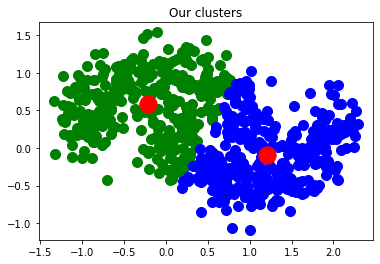

In [500]:
k=2
kmeans=KMeans(k,max_iter=10000,runs=20)
centroids,kmeans_items=kmeans.fit(X,Y)

color_s =["green","blue","navy","maroon",'orange'] 
for i in range(k):
    plt.scatter(kmeans_items[kmeans_items[:,2]==i,0] , kmeans_items[kmeans_items[:,2]==i,1] 
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(centroids[:,0] , centroids[:,1] , s = 300, color = 'red')
plt.title('Our clusters')
plt.show();

Iteration 1: log-likelihood is -1398.603461
Iteration 2: log-likelihood is -1393.737290
Iteration 3: log-likelihood is -1388.745843
Iteration 4: log-likelihood is -1380.915371
Iteration 5: log-likelihood is -1369.135334
Iteration 6: log-likelihood is -1353.728904
Iteration 7: log-likelihood is -1338.594814
Iteration 8: log-likelihood is -1328.926162
Iteration 9: log-likelihood is -1325.052040
Iteration 10: log-likelihood is -1323.946423
Iteration 11: log-likelihood is -1323.666447
Iteration 12: log-likelihood is -1323.588633
Terminate at 12-th iteration:log-likelihood is -1323.588633


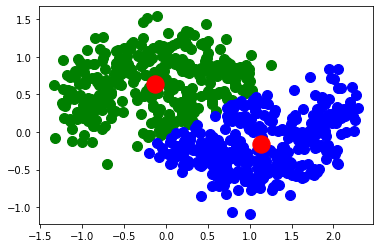

In [501]:
gmm=GaussianMixModel(X,k)
gmm.initialize_means(np.asmatrix(centroids))
gmm.fit();
gmm_result = gmm.predict()
data=pd.DataFrame(X)
data['Predicted'] = gmm_result

for i in range(k):
    plt.scatter(data[data['Predicted']==i][0], data[data['Predicted']==i][1]
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(np.array(gmm.mean_arr[:,0]).flatten() , np.array(gmm.mean_arr[:,1]).flatten() , s = 300, color = 'red')
plt.show();


In [505]:
X, Y = make_circles(n_samples=700, noise=0.2)

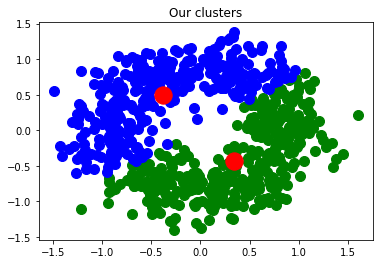

In [506]:
k=2
kmeans=KMeans(k,max_iter=10000,runs=20)
centroids,kmeans_items=kmeans.fit(X,Y)

color_s =["green","blue","navy","maroon",'orange'] 
for i in range(k):
    plt.scatter(kmeans_items[kmeans_items[:,2]==i,0] , kmeans_items[kmeans_items[:,2]==i,1] 
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(centroids[:,0] , centroids[:,1] , s = 300, color = 'red')
plt.title('Our clusters')
plt.show();

Iteration 1: log-likelihood is -1430.499494
Iteration 2: log-likelihood is -1420.656967
Iteration 3: log-likelihood is -1420.536376
Iteration 4: log-likelihood is -1420.405494
Iteration 5: log-likelihood is -1420.246694
Iteration 6: log-likelihood is -1420.047562
Iteration 7: log-likelihood is -1419.792324
Iteration 8: log-likelihood is -1419.458444
Iteration 9: log-likelihood is -1419.012108
Iteration 10: log-likelihood is -1418.400887
Iteration 11: log-likelihood is -1417.541077
Iteration 12: log-likelihood is -1416.295229
Iteration 13: log-likelihood is -1414.432159
Iteration 14: log-likelihood is -1411.558106
Iteration 15: log-likelihood is -1407.013733
Iteration 16: log-likelihood is -1399.794125
Iteration 17: log-likelihood is -1388.812963
Iteration 18: log-likelihood is -1374.346416
Iteration 19: log-likelihood is -1360.407653
Iteration 20: log-likelihood is -1352.311886
Iteration 21: log-likelihood is -1349.627012
Iteration 22: log-likelihood is -1348.909115
Iteration 23: log-l

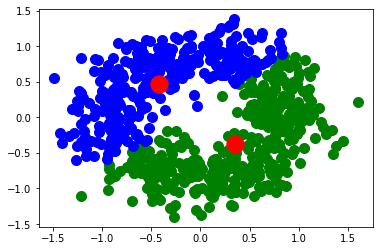

In [507]:
gmm=GaussianMixModel(X,k)
gmm.initialize_means(np.asmatrix(centroids))
gmm.fit();
gmm_result = gmm.predict()
data=pd.DataFrame(X)
data['Predicted'] = gmm_result

for i in range(k):
    plt.scatter(data[data['Predicted']==i][0], data[data['Predicted']==i][1]
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(np.array(gmm.mean_arr[:,0]).flatten() , np.array(gmm.mean_arr[:,1]).flatten() , s = 300, color = 'red')
plt.show();

### Reinforcement Learning:

At the bellow cell, besides the required libraries have been imported, feel free for changing the num_states variable with your desired number.

In [1]:
import numpy as np
import random
import gym

In [ ]:
env = gym.make("MountainCar-v0")
num_actions = 3
num_states = 50

# first I should note that first one is position and second one is velocity! 
# so each state should be recognized using two discretized states
q_table = np.zeros(shape=(num_states,num_states, num_actions))

# You may change the inputs of any function as you desire.
SPACE_LOW = env.observation_space.low
SPACE_HIGH = env.observation_space.high
DISCOUNT_FACTOR = 0.95
EXPLORATION = 0.15

EPISODES = 100000
STEP_COUNT_MAX = 20000
DISPLAY=False

#### Part 1:

Next cell wants you supplement two functions. First for transforming the continuous space into discrete one (in order to make using q_table feasible), second for updating q_values based on the last action done by agent.

In [40]:
def discretize_state():
    return np.abs(SPACE_HIGH-SPACE_LOW)/num_states

def env_state_to_Q_state(state):
    return np.round((state - SPACE_LOW)/discretize_state()).astype(int)

#p is position , v is velocity, p_ is position_new, v_ is velocity_new
def update_q(p, v, p_, v_, action, eta, reward):
    if np.random.uniform(0,1) < EXPLORATION:
        action_after = np.random.choice(env.action_space.n)
    else:
        action_after = np.argmax(q_table[p_][v_])
    q_table[p][v][action] = q_table[p][v][action] + eta * (reward + DISCOUNT_FACTOR *  q_table[p_][v_][action_after] - q_table[p][v][action])

#### Part 2:

At the following cell, the ends of two functions are getting current action based on the policy and defining the training process respectively.

In [59]:
# You may change the inputs of any function as you desire.
def get_action():
    global EXPLORATION
    sum_reward_every_thousand = 0
    eta = 0.1
    for episode in range(EPISODES):
        state = env.reset()
        sum_reward = 0
        
        if episode < 30000:
            EXPLORATION = 0.15
            eta = 0.1
        else:
            EXPLORATION = (0.15)* (0.99)**((episode-30000)//100)
            eta = (0.1) * (0.99)**((episode-30000)//10000)


        for step in range(STEP_COUNT_MAX):

            if episode % 1000 == 1 and DISPLAY:
                env.render()

            p, v = env_state_to_Q_state(state)
            if np.random.uniform(0, 1) < EXPLORATION:
                action = np.random.choice(env.action_space.n) 
            else:
                action = np.argmax(q_table[p][v])
            state, reward, done, _ = env.step(action)
            sum_reward += reward

            p_, v_ = env_state_to_Q_state(state)
            update_q(p,v,p_, v_, action, eta, reward)

            if done:
                break
        
        sum_reward_every_thousand+= sum_reward

        if episode % 1000 == 1:
            print(f'Episode: {episode}, Total Reward: {sum_reward}, Mean Reward for previous thousand: {sum_reward_every_thousand/1000}')
            sum_reward_every_thousand=0
        
        

def q_learning():
    return np.argmax(q_table, axis=2) 


def save_policy():
    np.save('policy.npy', q_learning())

In [60]:
get_action()

Episode: 1, Total Reward: -179.0, Mean Reward for previous thousand: -0.301
Episode: 1001, Total Reward: -193.0, Mean Reward for previous thousand: -157.109
Episode: 2001, Total Reward: -115.0, Mean Reward for previous thousand: -152.583
Episode: 3001, Total Reward: -117.0, Mean Reward for previous thousand: -143.079
Episode: 4001, Total Reward: -149.0, Mean Reward for previous thousand: -166.126
Episode: 5001, Total Reward: -115.0, Mean Reward for previous thousand: -160.521
Episode: 6001, Total Reward: -159.0, Mean Reward for previous thousand: -146.022
Episode: 7001, Total Reward: -150.0, Mean Reward for previous thousand: -145.918
Episode: 8001, Total Reward: -126.0, Mean Reward for previous thousand: -146.489
Episode: 9001, Total Reward: -146.0, Mean Reward for previous thousand: -144.533
Episode: 10001, Total Reward: -158.0, Mean Reward for previous thousand: -149.24
Episode: 11001, Total Reward: -147.0, Mean Reward for previous thousand: -145.605
Episode: 12001, Total Reward: -1

In [61]:
save_policy()

#### Part 3:

Ultimately, the score function examines the average performance of Agent (after nearly 1000 times) based on previous implementations.

In [62]:
# Attention: don't change this function. we will use this to grade your policy which you will hand in with policy.npy
# btw you can use it to see how you are performing. Uncomment two lines which are commented to be able to see what is happening visually.
def score():
    policy, scores = np.load("policy.npy"), []
    for episode in range(1000):
        print(f"******Episode {episode}")
        state, score, done, step = env_state_to_Q_state(env.reset()), 0, False, 0
        while not done:
            # time.sleep(0.04)
            p,v = state
            action = policy[p,v]
            state, reward, done, _ = env.step(action)
            state = env_state_to_Q_state(state)
            step += 1
            score += int(reward)
            
        print(f"Score:{score}")
        scores.append(score)
    print(f"Average score over 1000 run : {np.array(scores).mean()}")

score()

*****Episode 306
Score:-150
******Episode 307
Score:-156
******Episode 308
Score:-111
******Episode 309
Score:-91
******Episode 310
Score:-84
******Episode 311
Score:-109
******Episode 312
Score:-158
******Episode 313
Score:-104
******Episode 314
Score:-85
******Episode 315
Score:-108
******Episode 316
Score:-147
******Episode 317
Score:-104
******Episode 318
Score:-105
******Episode 319
Score:-90
******Episode 320
Score:-104
******Episode 321
Score:-106
******Episode 322
Score:-147
******Episode 323
Score:-104
******Episode 324
Score:-85
******Episode 325
Score:-104
******Episode 326
Score:-149
******Episode 327
Score:-90
******Episode 328
Score:-109
******Episode 329
Score:-85
******Episode 330
Score:-90
******Episode 331
Score:-93
******Episode 332
Score:-106
******Episode 333
Score:-156
******Episode 334
Score:-88
******Episode 335
Score:-84
******Episode 336
Score:-106
******Episode 337
Score:-95
******Episode 338
Score:-85
******Episode 339
Score:-125
******Episode 340
Score:-106